In [1]:
import sys
sys.path.append('../src/training-on-CM2.6')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xgcm
import cmocean

from helpers.cm26 import DatasetCM26

%load_ext autoreload
%autoreload 3

In [2]:
EXP1 = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subfilter/FGR3/EXP1/model/Tall.nc')
#EXP3 = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subfilter/FGR3/Collocated-NN-params/hdn-32-32/model/Tall.nc')

In [3]:
lores_static = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/static.nc', decode_times=False).isel(xq=slice(1,None), yq=slice(1,None))

grid_lores = xgcm.Grid(lores_static.isel(time=0).drop_vars('time').squeeze(), coords={
        'X': {'center': 'xh', 'right': 'xq'},
        'Y': {'center': 'yh', 'right': 'yq'}
    },
    boundary={"X": 'periodic', 'Y': 'fill'},
    fill_value = {'Y':0})

lores_static['dxBu'] = grid_lores.interp(lores_static.dxCu, 'Y')
lores_static['dyBu'] = grid_lores.interp(lores_static.dyCu, 'Y')

lores_static['dxT'] = grid_lores.interp(lores_static.dxCu, 'X')
lores_static['dyT'] = grid_lores.interp(lores_static.dyCu, 'X')

# Make offline prediction with ANN on filtered high-resolution data and evaluate skill

In [4]:
# NW2 data
ref_FGR3 = \
    xr.merge(
        [xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/filter_scale_0.75/merged_dataset.nc', decode_times=False).drop_vars(['hf','ef']),
         xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/filter_scale_0.75/interfaces-GMfilter.nc', decode_times=False)
        ]
    ).isel(xq=slice(1,None), yq=slice(1,None))#.isel(time=slice(0,1))

data = ref_FGR3[['uf','vf','SGSx','SGSy','Txx','Tyy','Txy']].rename({'uf':'u','vf':'v'}).fillna(0.).compute()
ds = DatasetCM26(data, lores_static)

In [5]:
%%time 
prediction = ds.predict_ANN(None, None, EXP1, \
              stencil_size=3, \
              gradient_features=['sh_xy', 'sh_xx', 'rel_vort'])

CPU times: user 1h 16min 59s, sys: 2min 1s, total: 1h 19min 1s
Wall time: 16min 27s


In [6]:
to_save = prediction.data[['ZB20u', 'ZB20v', 'Txx_pred', 'Tyy_pred', 'Txy_pred']].copy(deep=True).rename({'ZB20u': 'ZB2020u_noh', 'ZB20v': 'ZB2020v_noh'})

In [10]:
hu = (grid_lores.interp(ref_FGR3.hf,'X') + 1e-11)
hv = (grid_lores.interp(ref_FGR3.hf,'Y') + 1e-11)

Mxx = to_save.Txx_pred * lores_static.dyT**2 * ref_FGR3.hf
Mxy = grid_lores.interp(to_save.Txy_pred * ref_FGR3.hf,['X','Y']) * lores_static.dxBu**2 * lores_static.wet_c
to_save['ZB2020u'] = lores_static.wet_u * (grid_lores.diff(Mxx, 'X') / lores_static.dyCu + grid_lores.diff(Mxy, 'Y') / lores_static.dxCu) / (lores_static.dxCu * lores_static.dyCu) / hu

Myy = to_save.Tyy_pred * lores_static.dxT**2 * ref_FGR3.hf
Mxy = grid_lores.interp(to_save.Txy_pred * ref_FGR3.hf,['X','Y']) * lores_static.dyBu**2 * lores_static.wet_c
to_save['ZB2020v'] = lores_static.wet_v * (grid_lores.diff(Myy, 'Y') / lores_static.dxCv + grid_lores.diff(Mxy, 'X') / lores_static.dyCv) / (lores_static.dxCv * lores_static.dyCv) / hv

In [11]:
to_save['dEdt'] = (grid_lores.interp(to_save['ZB2020u'] * data.u, 'X') + grid_lores.interp(to_save['ZB2020v'] * data.v, 'Y')) * lores_static.wet

In [12]:
to_save['dEdt_noh'] = (grid_lores.interp(to_save['ZB2020u_noh'] * data.u, 'X') + grid_lores.interp(to_save['ZB2020v_noh'] * data.v, 'Y')) * lores_static.wet

In [13]:
Tdd = 0.5 * (to_save['Txx_pred'] - to_save['Tyy_pred'])
Ttr = 0.5 * (to_save['Txx_pred'] + to_save['Tyy_pred'])
# Positive number means backscatter
to_save['SGS_back'] = - (Tdd * ref_FGR3['sh_xx'] + Ttr * ref_FGR3['div'] + to_save['Txy_pred'] * ref_FGR3['sh_xy_h'])

In [14]:
def M2(x,y=None,centered=False,dims=None,exclude_dims='zl', mask=None):
    if dims is None and exclude_dims is not None:
        dims = []
        for dim in x.dims:
            if dim not in exclude_dims:
                dims.append(dim)

    if mask is not None:
        x = x * mask
        if y is not None:
            y = y * mask

    if y is None:
        y = x
    if centered:
        return (x*y).mean(dims) - x.mean(dims)*y.mean(dims)
    else:
        return (x*y).mean(dims)

def M2u(x,y=None,centered=False,dims='time'):
    return grid_lores.interp(M2(x,y,centered,dims),'X')
def M2v(x,y=None,centered=False,dims='time'):
    return grid_lores.interp(M2(x,y,centered,dims),'Y')

errxx = ref_FGR3.Txx - to_save.Txx_pred
erryy = ref_FGR3.Tyy - to_save.Tyy_pred
errxy = ref_FGR3.Txy - to_save.Txy_pred

to_save['R2T_map'] =  1 - (M2(errxx, dims='time') + M2(erryy, dims='time') + M2(errxy, dims='time')) / (M2(ref_FGR3.Txx, dims='time') + M2(ref_FGR3.Tyy, dims='time') + M2(ref_FGR3.Txy, dims='time'))

errx = ref_FGR3.SGSx - to_save.ZB2020u_noh
erry = ref_FGR3.SGSy - to_save.ZB2020v_noh

to_save['R2_noh_map']  = 1 - (M2u(errx) + M2v(erry)) / (M2u(ref_FGR3.SGSx) + M2v(ref_FGR3.SGSy))

errx = ref_FGR3.SGSx - to_save.ZB2020u
erry = ref_FGR3.SGSy - to_save.ZB2020v

to_save['R2_map']  = 1 - (M2u(errx) + M2v(erry)) / (M2u(ref_FGR3.SGSx) + M2v(ref_FGR3.SGSy))

In [15]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    to_save = to_save.transpose('time','zl',...).astype('float32').compute()

[########################################] | 100% Completed | 80.51 ss


In [16]:
to_save.to_netcdf('/scratch/pp2681/mom6/Neverworld2/simulations/R32/filter_scale_0.75/EXP1-offline.nc')

# Visualising offline skill in NW2

In [2]:
ref_FGR3 = \
    xr.merge(
        [xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/filter_scale_0.75/merged_dataset.nc', decode_times=False).drop_vars(['hf','ef']),
         xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/filter_scale_0.75/interfaces-GMfilter.nc', decode_times=False)
        ]
    ).isel(xq=slice(1,None), yq=slice(1,None))

In [3]:
skill = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/filter_scale_0.75/EXP1-offline.nc')

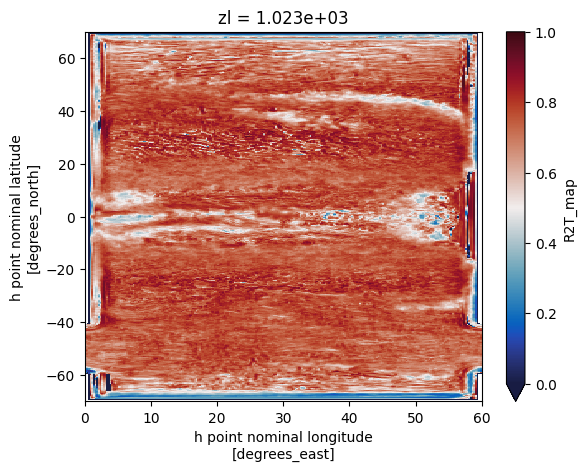

In [24]:
skill.R2T_map.isel(zl=0).plot(vmin=0, vmax=1, cmap=cmocean.cm.balance)

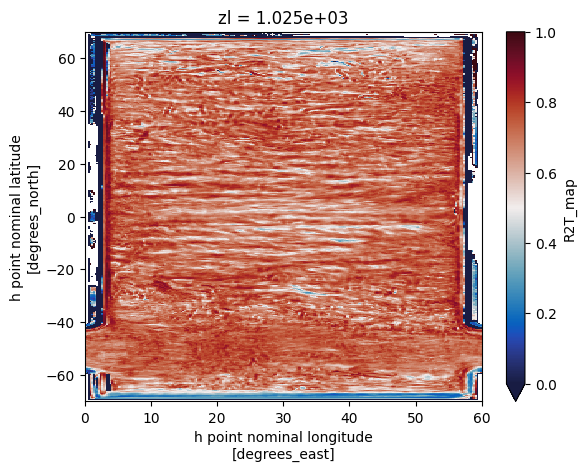

In [25]:
skill.R2T_map.isel(zl=5).plot(vmin=0, vmax=1, cmap=cmocean.cm.balance)

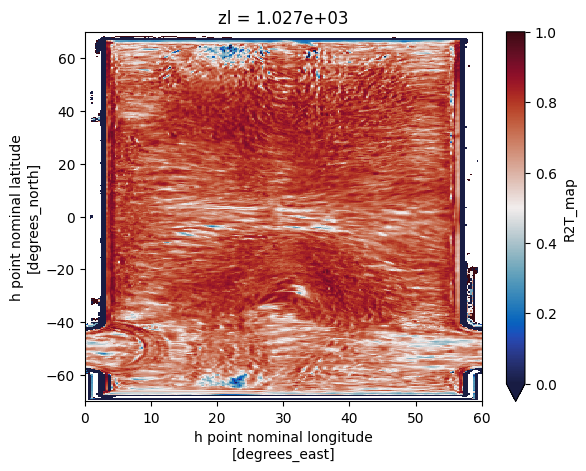

In [26]:
skill.R2T_map.isel(zl=10).plot(vmin=0, vmax=1, cmap=cmocean.cm.balance)

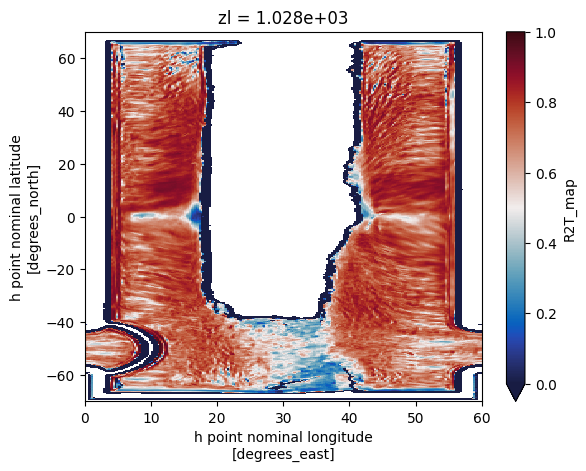

In [28]:
skill.R2T_map.isel(zl=14).plot(vmin=0, vmax=1, cmap=cmocean.cm.balance)

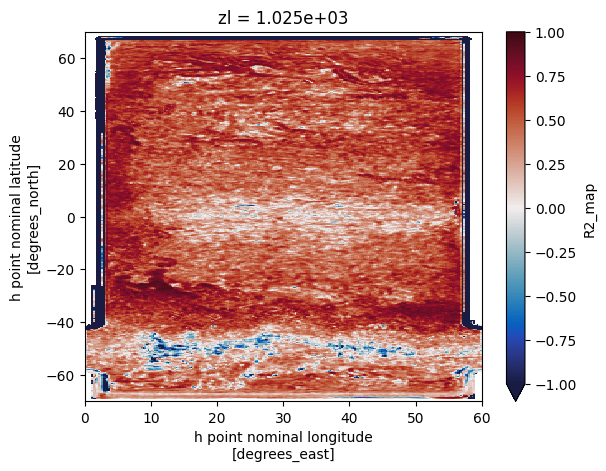

In [37]:
skill.R2_map.isel(zl=5).plot(vmin=-1, vmax=1, cmap=cmocean.cm.balance)

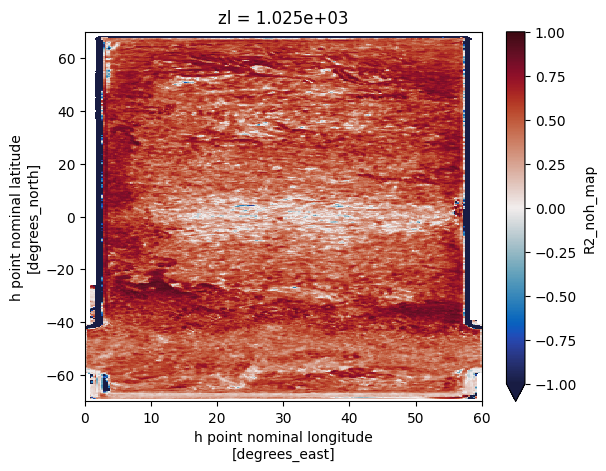

In [36]:
skill.R2_noh_map.isel(zl=5).plot(vmin=-1, vmax=1, cmap=cmocean.cm.balance)

Correlation: 0.4770451486110687
Relative Error: 0.9956658482551575
R2 =  -0.10805952548980713
R2 max =  0.22932195663452148
Optinal scaling: 0.45188838243484497
Nans [test/control]: [4390, 4390]


array([[<Axes: title={'center': 'Tested field'}, xlabel='h point nominal longitude\n[degrees_east]', ylabel='h point nominal latitude\n[degrees_north]'>,
        <Axes: title={'center': 'Control field'}, xlabel='h point nominal longitude\n[degrees_east]', ylabel='h point nominal latitude\n[degrees_north]'>],
       [<Axes: title={'center': 'Tested field $-$ Control field'}, xlabel='h point nominal longitude\n[degrees_east]', ylabel='h point nominal latitude\n[degrees_north]'>,
        <Axes: >]], dtype=object)

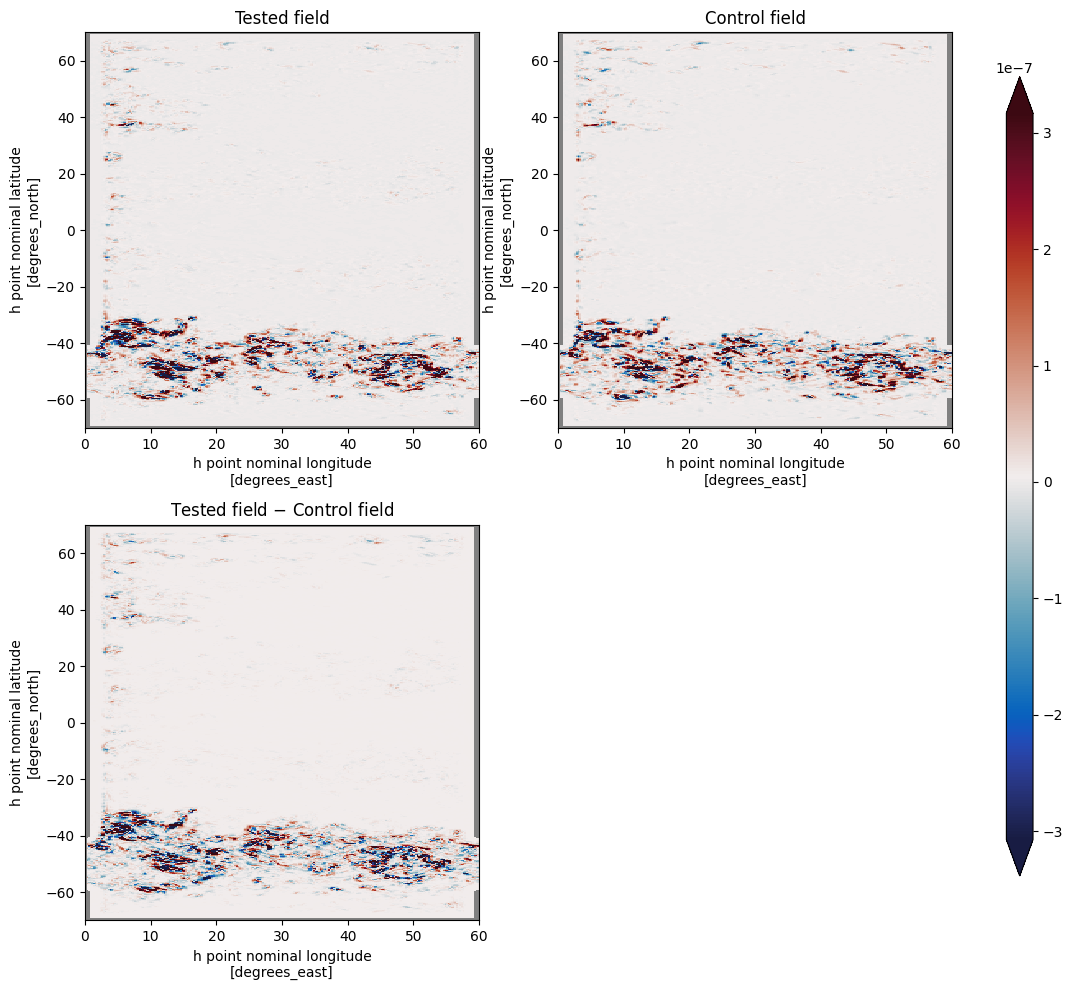

In [21]:
compare(skill.SGS_back.isel(time=0,zl=3), ref_FGR3.SGS_back.isel(time=0,zl=3), selector=lambda x: x)

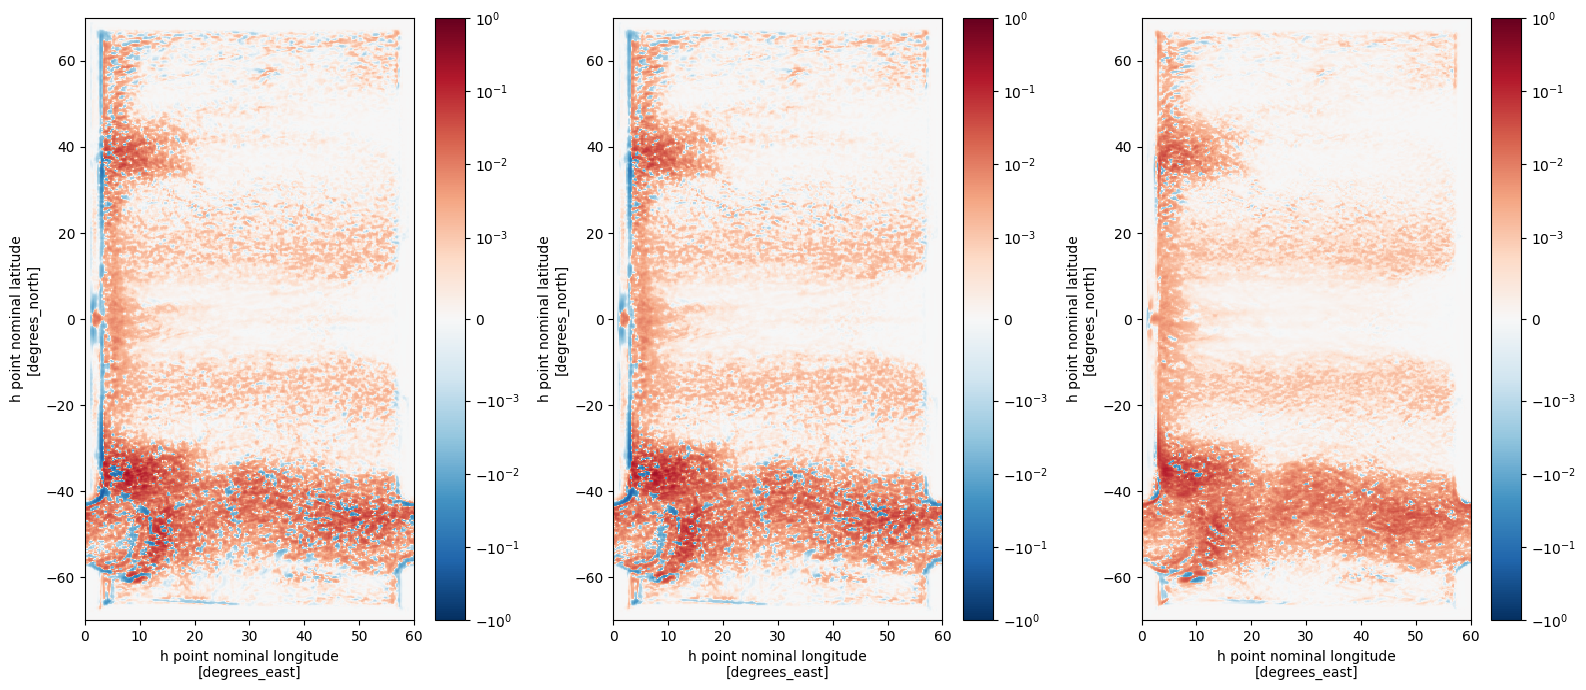

In [22]:
import matplotlib as mpl
plt.figure(figsize=(16,7))
plt.subplot(1,3,1)
(1e+3 * ref_FGR3.hf * skill.dEdt).sum('zl').mean('time').plot(norm = mpl.colors.SymLogNorm(linthresh=1e-3, vmin=-1, vmax=1))
plt.subplot(1,3,2)
(1e+3 * ref_FGR3.hf * skill.dEdt_noh).sum('zl').mean('time').plot(norm = mpl.colors.SymLogNorm(linthresh=1e-3, vmin=-1, vmax=1))
plt.subplot(1,3,3)
(1e+3 * ref_FGR3.hf * skill.SGS_back).sum('zl').mean('time').plot(norm = mpl.colors.SymLogNorm(linthresh=1e-3, vmin=-1, vmax=1))

plt.tight_layout()

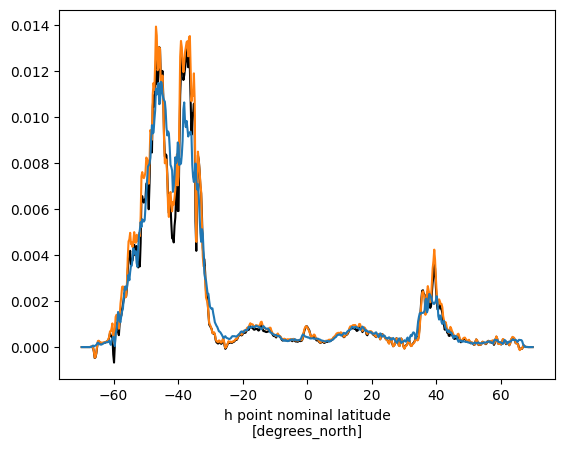

In [26]:
(1e+3 * ref_FGR3.hf * skill.dEdt).sum('zl').mean('time').mean('xh').plot(color='k')
(1e+3 * ref_FGR3.hf * skill.dEdt_noh).sum('zl').mean('time').mean('xh').plot(color='tab:orange')
(1e+3 * ref_FGR3.hf * skill.SGS_back).sum('zl').mean('time').mean('xh').plot(color='tab:blue')